In [6]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + tf.keras.backend.epsilon()))

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate, Input,Dense

# Load the saved PCG and ECG models
pcg_model = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\VGG16\VGG16_PCG\VGG16_PCG_epoch_7.keras")
ecg_model = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\VGG16\VGG16_ECG\VGG16_ECG_epoch_49.keras")

# Rename the input layers of the ECG model
input_ecg = Input(shape=ecg_model.input_shape[1:], name='ecg_input')
ecg_output = ecg_model(input_ecg)

# Extract the output layers of both models
pcg_output = pcg_model.output

# Concatenate the outputs
concatenated = concatenate([pcg_output, ecg_output],name='concatenated_layer')

# Define the fused model
input_pcg = pcg_model.input

# Define a Dense layer for binary classification
fused_model_output = Dense(1, activation='sigmoid')(concatenated)  # Assuming binary classification

fused_model = Model(inputs=[input_pcg, input_ecg], outputs=fused_model_output)

# Compile the fused model
fused_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score])


# Now you can use fused_model for predictions



In [22]:
print(fused_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['vgg16_input[0][0]']         
                                                          8                                       
                                                                                                  
 flatten_1 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 256)                  6422784   ['flatten_1[0][0]']       

In [1]:
import os
import numpy as np
from keras.preprocessing import image

def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    label_map = {'normal': 0, 'abnormal': 1}
    
    for label in label_map.keys():
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array *= (1.0/255)  # Apply rescaling
            images.append(img_array)
            labels.append(label_map[label])
            
    return np.array(images), np.array(labels)

In [2]:
# Define path to main directory containing normal and abnormal subdirectories
ECG_path = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\ECG_scalogram_divided"
PCG_path = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\PCG_scalogram_divided"

In [3]:
# Load actual data arrays for ECG and PCG

X_ecg, y_ecg = load_images_from_directory(ECG_path, target_size=(224, 224))
X_pcg, y_pcg = load_images_from_directory(PCG_path, target_size=(224, 224))

In [7]:
print(y_ecg,y_pcg)

[0 0 0 ... 1 1 1] [0 0 0 ... 1 1 1]


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_ecg, X_val_ecg, y_train, y_val_ecg = train_test_split(X_ecg, y_ecg, test_size=0.2, random_state=41)
X_train_pcg, X_val_pcg, y_train, y_val_pcg = train_test_split(X_pcg, y_ecg, test_size=0.2, random_state=41)

In [9]:
print(y_val_pcg,y_val_ecg)

[1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0
 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1
 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="E:\\MAIN PROJECT\\FILTERD CODES\\data splitting\\trained models\\VGG16\\VGG16_fused_1\\VGG16_fused_epoch_{epoch}.keras",  # Save the model with the epoch number in the filename
    save_weights_only=False,  # Save the entire model (architecture, weights, and training configuration)
    save_best_only=False,  # Save the model after each epoch, regardless of performance
    monitor='val_loss',  # Quantity to monitor on the validation set
    mode='min',  # Mode can be 'min' or 'max' depending on whether you want to minimize or maximize the monitored quantity
    verbose=1
)


# Define a callback for early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor on the validation set
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)
# Train the fused model
history = fused_model.fit(
    [X_train_pcg, X_train_ecg],  # Input data: PCG and ECG images
    y_train,                      # Target labels
    batch_size=64,                # Batch size
    epochs=100,                    # Number of epochs
    validation_data=([X_val_pcg, X_val_ecg], y_val_ecg),        # Fraction of training data used for validation
    callbacks=[early_stopping_callback, checkpoint_callback]  # Callbacks for early stopping and model checkpoint
)

Epoch 1/100


44/44 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7105 - precision: 0.7116 - recall: 1.0000 - f1_score: 0.8303 
Epoch 1: saving model to E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\VGG16\VGG16_fused_1\VGG16_fused_epoch_1.keras
44/44 [==============================] - 618s 13s/step - loss: 0.5687 - accuracy: 0.7105 - precision: 0.7116 - recall: 1.0000 - f1_score: 0.8303 - val_loss: 0.5594 - val_accuracy: 0.7126 - val_precision: 0.7135 - val_recall: 1.0000 - val_f1_score: 0.8314
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7105 - precision: 0.7116 - recall: 1.0000 - f1_score: 0.8299
Epoch 2: saving model to E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\VGG16\VGG16_fused_1\VGG16_fused_epoch_2.keras
44/44 [==============================] - 532s 12s/step - loss: 0.5542 - accuracy: 0.7105 - precision: 0.7116 - recall: 1.0000 - f1_score: 0.8299 - val_loss: 0.5494 - val_accuracy

In [21]:
import re

# Open the text document in read mode
with open(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\outputs\VGG16\VGG16_fused\VGG16_fused.txt", 'r') as file:
    # Read the entire contents of the file
    text = file.read()

# Regular expression pattern to match accuracy values
pattern1 = r"accuracy: (\d+\.\d+)"
pattern2 = r"val_accuracy: (\d+\.\d+)"
pattern3 = r"loss: (\d+\.\d+)"
pattern4 = r"val_loss: (\d+\.\d+)"


# Find all accuracy values using regex
train_accuracy1 = re.findall(pattern1, text)
val_accuracy = re.findall(pattern2, text)
train_loss1 = re.findall(pattern3, text)
val_loss = re.findall(pattern4, text)

# Convert accuracy values to float
train_accuracy1 = [float(value) for value in train_accuracy1]
val_accuracy = [float(value) for value in val_accuracy]
train_loss1 = [float(value) for value in train_loss1]
val_loss = [float(value) for value in val_loss]



In [27]:
train_accuracy=[]
train_loss=[]
i=-2
while i<296:
    train_accuracy.append(train_accuracy1[i+3])
    train_loss.append(train_loss1[i+3])
    i+=3


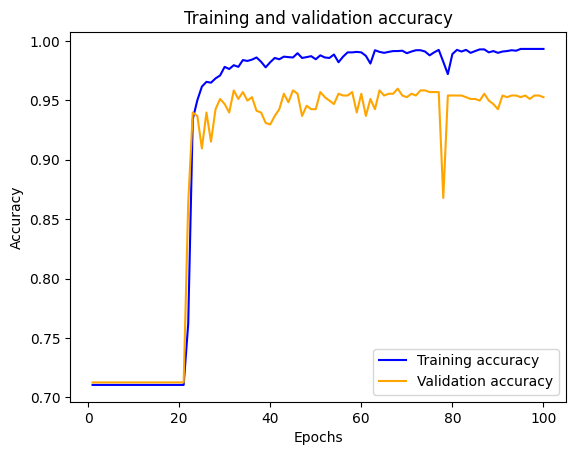

In [24]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 101)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

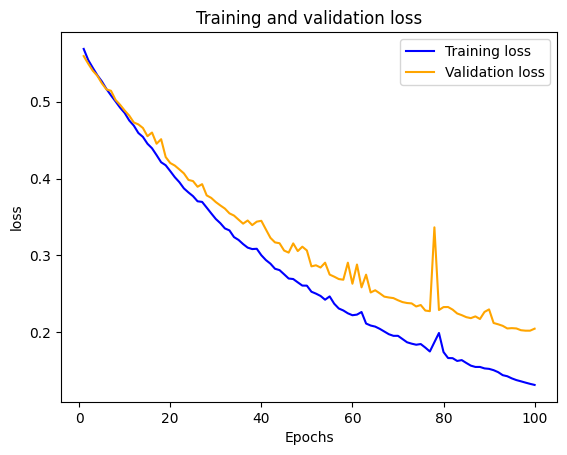

In [28]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 101)
plt.plot(epochs, train_loss ,'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

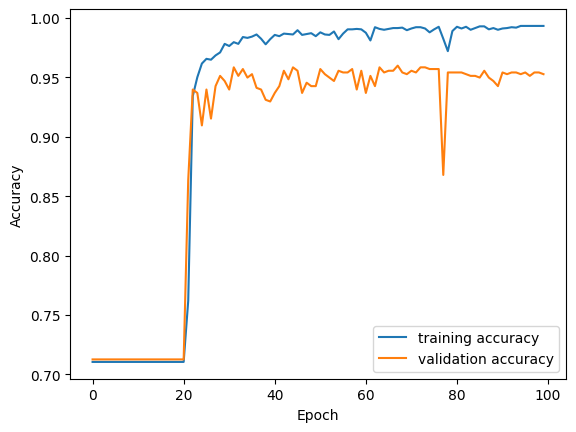

In [28]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

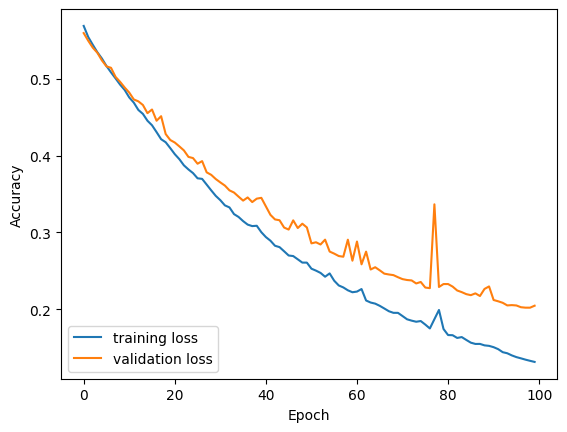

In [27]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.show()

In [7]:
from tensorflow.keras.models import load_model
VGG16_fused = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\VGG16\VGG16_fused_1\VGG16_fused_epoch_99.keras",custom_objects={'precision': precision, 'recall': recall, 'f1_score': f1_score})

In [8]:
y_pred_prob_train = VGG16_fused.predict([X_train_pcg, X_train_ecg])


87/87 [==============================] - 431s 5s/step


In [31]:
y_pred_train = np.round(y_pred_prob_train)

In [32]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm_fused_train = confusion_matrix(y_train, y_pred_train)

print("cm ecg train:",cm_fused_train)

cm ecg train: [[ 792   13]
 [   6 1970]]


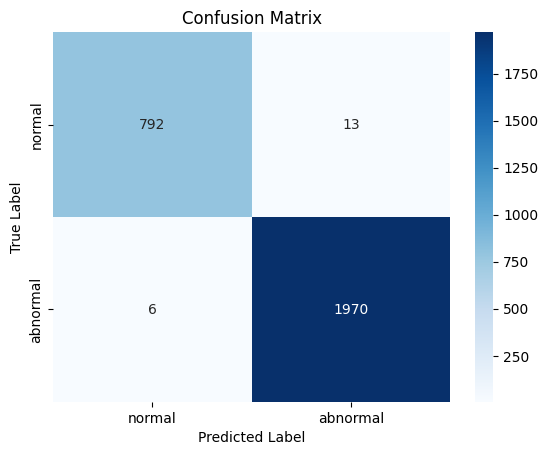

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       805
           1       0.99      1.00      1.00      1976

    accuracy                           0.99      2781
   macro avg       0.99      0.99      0.99      2781
weighted avg       0.99      0.99      0.99      2781



In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with values
sns.heatmap(cm_fused_train, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

In [9]:
y_pred_prob_val = VGG16_fused.predict([X_val_pcg, X_val_ecg])

22/22 [==============================] - 107s 5s/step


In [18]:
y_pred_val = np.round(y_pred_prob_val)

In [36]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm_fused_val = confusion_matrix(y_val_ecg, y_pred_val)

print("cm fused val:",cm_fused_val)

cm fused val: [[180  20]
 [ 12 484]]


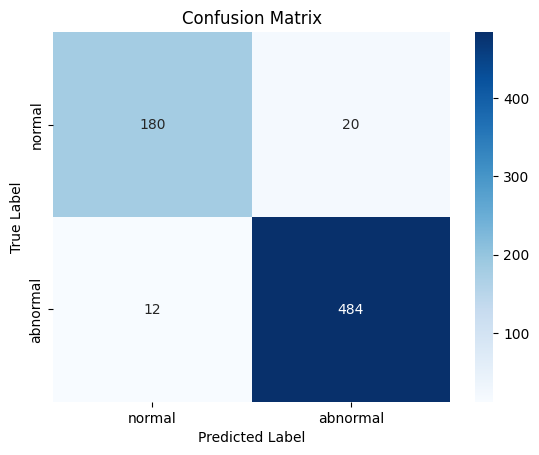

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       200
           1       0.96      0.98      0.97       496

    accuracy                           0.95       696
   macro avg       0.95      0.94      0.94       696
weighted avg       0.95      0.95      0.95       696



In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with values
sns.heatmap(cm_fused_val, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_val_ecg, y_pred_val))

In [38]:
def calculate_metrics(confusion_matrix):
    # Extract values from confusion matrix
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[0][0]
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return precision, recall, f1_score, accuracy,specificity

In [40]:
cm_fused_val= [[180 , 20],[ 12 ,484]]
# Calculate metrics
val_precision, val_recall, val_f1_score, val_accuracy, val_specificity = calculate_metrics(cm_fused_val)

# Print results
print("Precision:", val_precision)
print("Recall (Sensitivity):", val_recall)
print("F1 Score:", val_f1_score)
print("Accuracy:", val_accuracy)
print("specificity:",val_specificity)

Precision: 0.9603174603174603
Recall (Sensitivity): 0.9758064516129032
F1 Score: 0.9680000000000001
Accuracy: 0.9540229885057471
specificity: 0.9


In [39]:
cm_fused_train= [[ 792 ,  13],[   6, 1970]]
# Calculate metrics
train_precision, train_recall, train_f1_score, train_accuracy, train_specificity = calculate_metrics(cm_fused_train)

# Print results
print("Precision:", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1 Score:", train_f1_score)
print("Accuracy:", train_accuracy)
print("specificity:",train_specificity)

Precision: 0.9934442763489663
Recall (Sensitivity): 0.9969635627530364
F1 Score: 0.9952008082849204
Accuracy: 0.9931679252067601
specificity: 0.9838509316770186


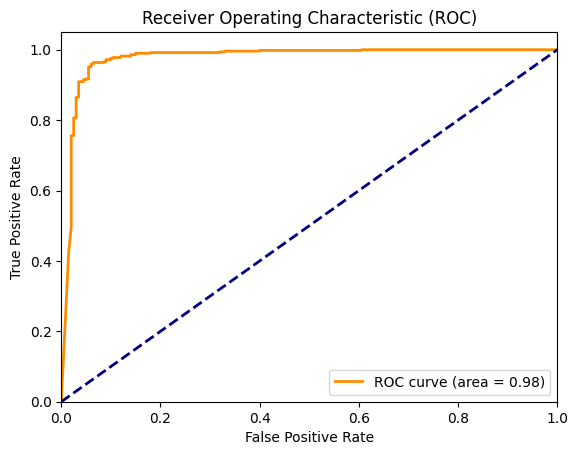

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val_ecg, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

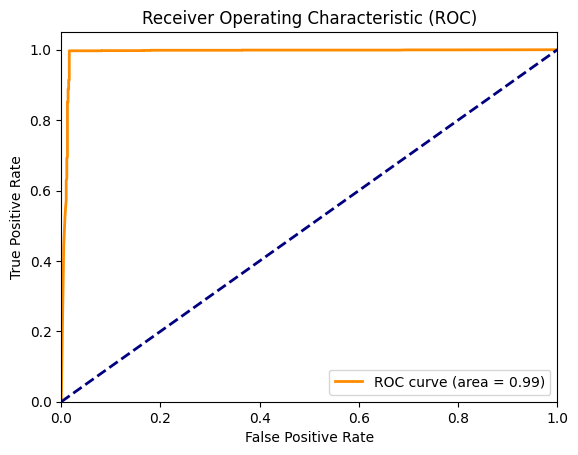

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

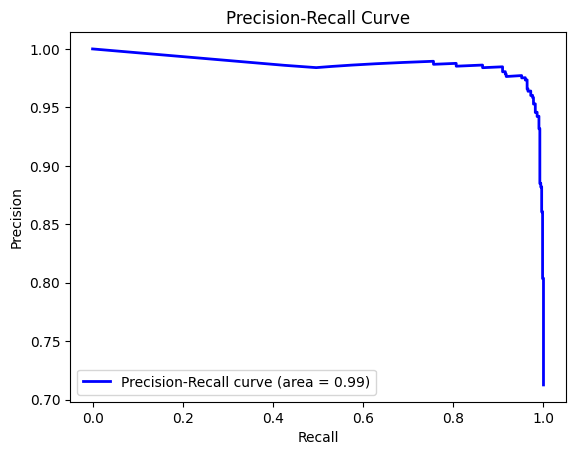

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val_ecg, y_pred_prob_val)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

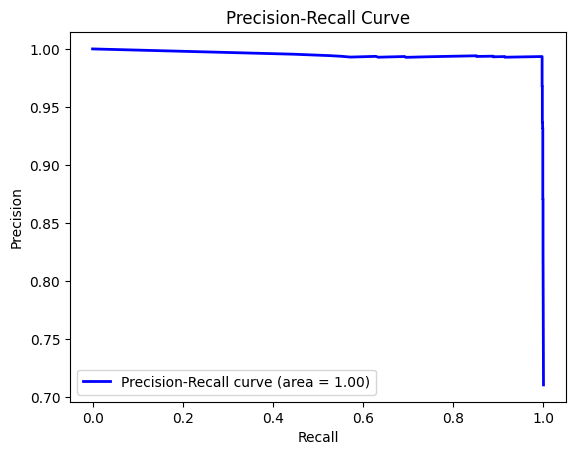

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob_train)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()